In [29]:
# @author Nikhil Maserang
# @date 2023/04/12

import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
import sxm_reader as sxm

Available channels:
['Z', 'LockIn_Y', 'Current']


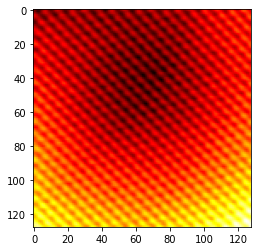

In [30]:
# get sxm data from file and plot it
IMAGE_NAME = "testing.sxm"

file_class = sxm.NanonisSXM(IMAGE_NAME)
file_class.list_channels()

image_data = file_class.retrieve_channel_data('Z')
plt.imshow(image_data, cmap="hot")

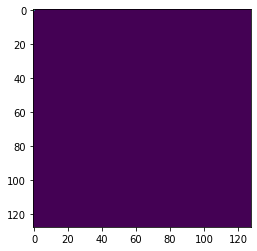

In [31]:
# run fft on image and display it
fft_image_data = fft.fft2(image_data)

plt.imshow(abs(fft_image_data))